In [22]:
import os
import math
import h5py
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 13

RANDOM_STATE = 42  
np.random.seed(RANDOM_STATE)


## Read the Data 

In [23]:
DATA_PATH = "sample_2e7_design_precessing_higherordermodes_3detectors.h5"
# Available keys 
if os.path.exists(DATA_PATH):
    with h5py.File(DATA_PATH, "r") as f:
        print("Available keys:", list(f.keys()))


Available keys: ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


In [24]:

#I don't use 'snr' as a feature for classification (it's the answer)
FEATURES = [
    "chi1x","chi1y","chi1z","chi2x","chi2y","chi2z",
    "dec","iota","mtot","psi","q","ra","z"
]

TARGET_DET = "det"   # 0/1 classification label (if snr < or > 12)
TARGET_SNR = "snr"   # for the regression

# Read a limited quantity of data 
HOW_MANY = int(1e5)   

#Load features and labels
def load_arrays(path, features, target_det, target_snr=None, how_many=int(1e5)):
    with h5py.File(path, "r") as f:
        n_total = len(f[target_det])
        n = min(int(how_many), n_total)
        X_list = []
        for key in features:
            X_list.append(f[key][:n])  # reads a slice [0:n] for each dataset
        X = np.vstack(X_list).T
        y_det = f[target_det][:n]
        y_snr = f[target_snr][:n]
    return X, y_det, y_snr

X, y, y_snr = load_arrays(DATA_PATH, FEATURES, TARGET_DET, TARGET_SNR, HOW_MANY)
pos_rate = y.mean()
print(f"Loaded X shape: {X.shape}")
print(f"Positive (det=1) rate in sample: {pos_rate:.5f}")


Loaded X shape: (100000, 13)
Positive (det=1) rate in sample: 0.14382


In [25]:
#Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (70000, 13)  Test shape: (30000, 13)


##  Definition of the metrics

In [26]:

#Definition of completeness (TP / (TP + FN))
def completeness(tp, fn):
    denom = tp + fn
    return tp / denom if denom > 0 else np.nan

#Definition of contamination (FP / (TP + FP))
def contamination(fp, tp):
    denom = tp + fp
    return fp / denom if denom > 0 else np.nan

# Compute metrics 
def evaluate_clf(name, clf, X_te, y_te, threshold=None, proba=None):
    if (threshold is not None) and (proba is not None):
        y_pred = (proba >= threshold).astype(int)
    else:
        y_pred = clf.predict(X_te)

    C = confusion_matrix(y_te, y_pred)
    tn, fp, fn, tp = C.ravel()

    metrics = {
        "accuracy": accuracy_score(y_te, y_pred), # (TP+TN)/(TP+TN+FP+FN)
        "precision": precision_score(y_te, y_pred, zero_division=0), # (1-contamination)
        "completeness": completeness(tp, fn),
        "contamination": contamination(fp, tp),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
    }

    print(f"\n[{name}]")
    print("Confusion matrix:\n", C)
    print(f"Accuracy:        {metrics['accuracy']:.4f}")
    print(f"Precision:       {metrics['precision']:.4f}")
    print(f"Completeness:    {metrics['completeness']:.4f}")
    print(f"Contamination:   {metrics['contamination']:.4f}")
    return metrics


## Decision Tree 

Decision Tree ROC AUC: 0.9706

[DecisionTree]
Confusion matrix:
 [[25159   526]
 [  743  3572]]
Accuracy:        0.9577
Precision:       0.8716
Completeness:    0.8278
Contamination:   0.1284


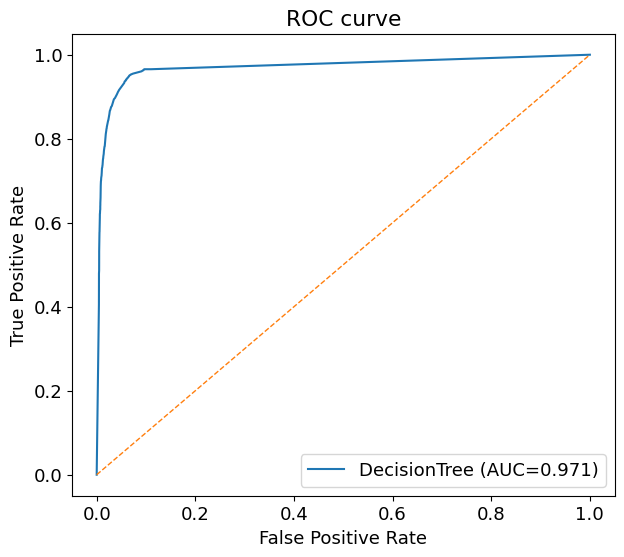

In [27]:
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=10,
    criterion="entropy",
)
dt.fit(X_train, y_train)

# Probabilities for ROC
y_prob_dt = dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thr_dt = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)
print("Decision Tree ROC AUC:", round(auc_dt, 4))

#print the metrics
_ = evaluate_clf("DecisionTree", dt, X_test, y_test)

# ROC curve
plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"DecisionTree (AUC={auc_dt:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()


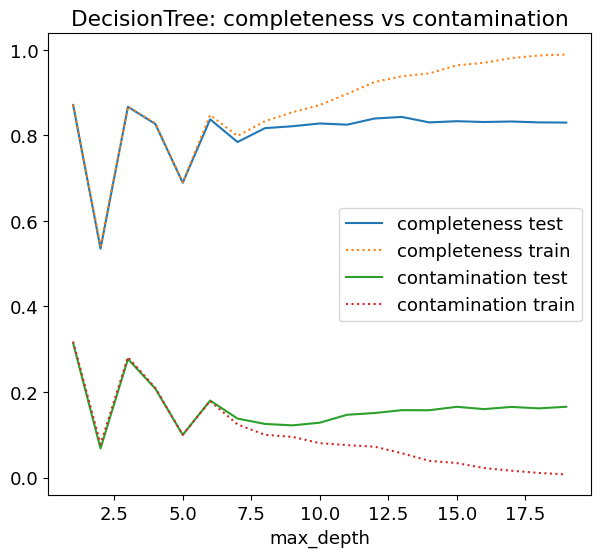

In [28]:
#Completness and contamination varying the depth of the tree
md_vals = np.arange(1, 20)
comp_te, cont_te, comp_tr, cont_tr = [], [], [], []

for md in md_vals:
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=md, criterion="entropy")
    clf.fit(X_train, y_train)

    # Test
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    comp_te.append(completeness(tp, fn))
    cont_te.append(contamination(fp, tp))

    # Train
    y_pred_tr = clf.predict(X_train)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_tr).ravel()
    comp_tr.append(completeness(tp, fn))
    cont_tr.append(contamination(fp, tp))

# Plot
plt.figure()
plt.plot(md_vals, comp_te, label="completeness test")
plt.plot(md_vals, comp_tr, linestyle="dotted", label="completeness train")
plt.plot(md_vals, cont_te, label="contamination test")
plt.plot(md_vals, cont_tr, linestyle="dotted", label="contamination train")
plt.xlabel("max_depth")
plt.title("DecisionTree: completeness vs contamination")
plt.legend()
plt.show()




In [29]:
# Reasonable depth before clear overfitting 
BEST_MD = 7 #train and test start to diverge
clf_md = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=BEST_MD, criterion="entropy")
clf_md.fit(X_train, y_train)
_ = evaluate_clf(f"DecisionTree (max_depth)={BEST_MD}", clf_md, X_test, y_test)


[DecisionTree (max_depth)=7]
Confusion matrix:
 [[25143   542]
 [  930  3385]]
Accuracy:        0.9509
Precision:       0.8620
Completeness:    0.7845
Contamination:   0.1380


## Random Forest 

RandomForest ROC AUC: 0.9874

[RandomForest]
Confusion matrix:
 [[25369   316]
 [  938  3377]]
Accuracy:        0.9582
Precision:       0.9144
Completeness:    0.7826
Contamination:   0.0856


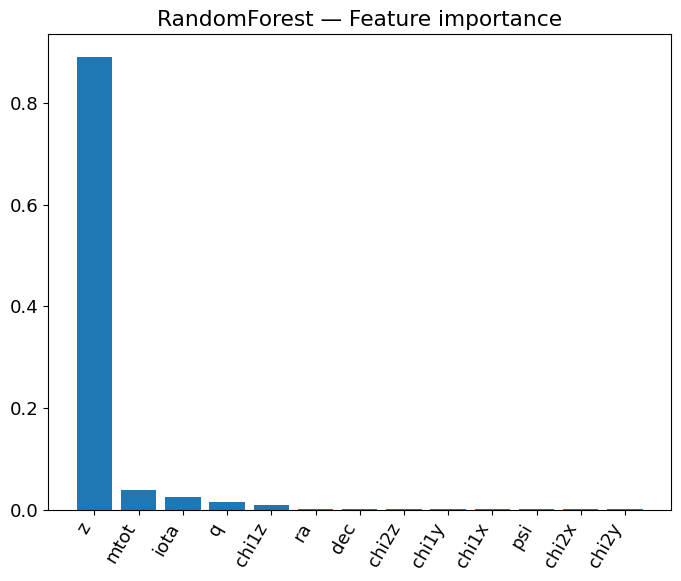

In [30]:


rf = RandomForestClassifier(
    n_estimators=200, #n of trees
    max_depth=7,
    criterion="entropy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, y_prob_rf)
print("RandomForest ROC AUC:", round(auc_rf, 4))
_ = evaluate_clf("RandomForest", rf, X_test, y_test)

# Feature importances
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
plt.figure()
plt.bar(range(len(FEATURES)), importances[order])
plt.xticks(range(len(FEATURES)), [FEATURES[i] for i in order], rotation=60, ha="right")
plt.title("RandomForest — Feature importance")
plt.tight_layout()
plt.show()


## Gradient Boosting 

In [31]:


gbdt = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbdt.fit(X_train, y_train)

y_prob_gbdt = gbdt.predict_proba(X_test)[:,1]
auc_gbdt = roc_auc_score(y_test, y_prob_gbdt)
print("GBDT ROC AUC:", round(auc_gbdt, 4))
_ = evaluate_clf("GradientBoosting", gbdt, X_test, y_test)


GBDT ROC AUC: 0.9921

[GradientBoosting]
Confusion matrix:
 [[25315   370]
 [  636  3679]]
Accuracy:        0.9665
Precision:       0.9086
Completeness:    0.8526
Contamination:   0.0914


##  Logistic Regression (and PCA)

In [32]:
# Logistic regression
logit = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])
logit.fit(X_train, y_train)
y_prob_logit = logit.predict_proba(X_test)[:,1]
auc_logit = roc_auc_score(y_test, y_prob_logit)
print("LogisticRegression ROC AUC:", round(auc_logit, 4))
_ = evaluate_clf("LogisticRegression", logit, X_test, y_test)


LogisticRegression ROC AUC: 0.9765

[LogisticRegression]
Confusion matrix:
 [[23001  2684]
 [  232  4083]]
Accuracy:        0.9028
Precision:       0.6034
Completeness:    0.9462
Contamination:   0.3966


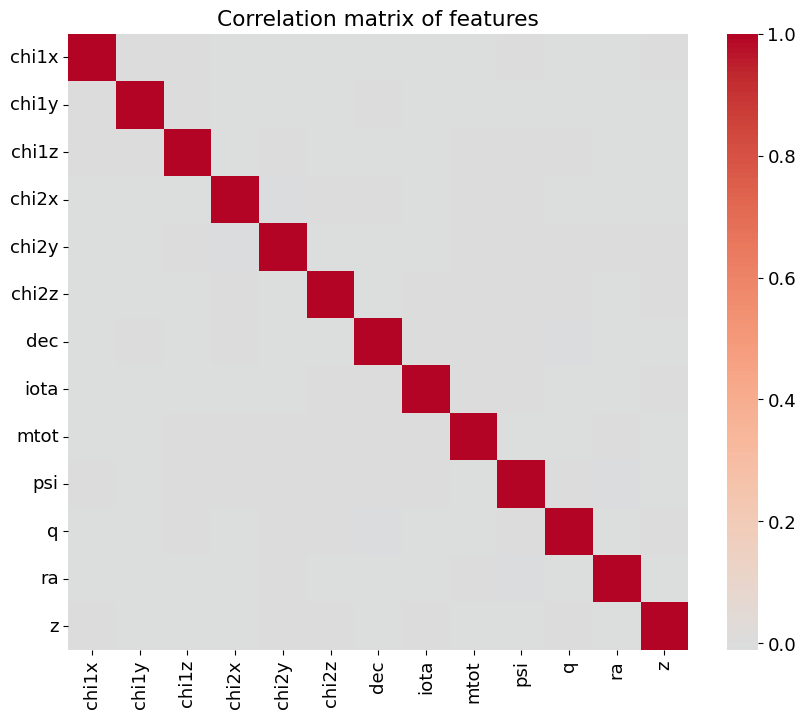

In [33]:
import seaborn as sns  
import pandas as pd

#Correlation matrix
df = pd.DataFrame(X_train, columns=FEATURES)
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm",  center=0)
plt.title("Correlation matrix of features")
plt.show()


In [34]:

# With PCA (not useful since features are not correlated)
logit_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8, random_state=RANDOM_STATE)),  # tweak
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])
logit_pca.fit(X_train, y_train)
y_prob_lp = logit_pca.predict_proba(X_test)[:,1]
auc_lp = roc_auc_score(y_test, y_prob_lp)
print("LogisticRegression+PCA ROC AUC:", round(auc_lp, 4))
_ = evaluate_clf("LogisticRegression+PCA", logit_pca, X_test, y_test)


LogisticRegression+PCA ROC AUC: 0.8487

[LogisticRegression+PCA]
Confusion matrix:
 [[19418  6267]
 [  953  3362]]
Accuracy:        0.7593
Precision:       0.3492
Completeness:    0.7791
Contamination:   0.6508


##  Regression `snr` 

In [35]:
# Predict continuous snr, then apply threshold=12.
Xtr, Xte, snr_tr, snr_te = train_test_split(X, y_snr, test_size=0.30, random_state=RANDOM_STATE)

gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr.fit(Xtr, snr_tr)

snr_pred = gbr.predict(X_test)  
det_pred = (snr_pred >= 12.0).astype(int)

C = confusion_matrix(y_test, det_pred)
tn, fp, fn, tp = C.ravel()
print("Regress-then-threshold confusion matrix:\n", C)
print("Completeness:", completeness(tp, fn))
print("Contamination:", contamination(fp, tp))


Regress-then-threshold confusion matrix:
 [[25026   659]
 [  952  3363]]
Completeness: 0.7793742757821552
Contamination: 0.16384883142715068
